In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

In [3]:
model_path = "../../thesis/models/DescriptorHomo/HH/"

# Molecules 

In [4]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"
basis = "6-311++g**"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)

In [5]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"

data = ScreenedData(r_max=10)

data.include(data_path = "../../thesis/dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../thesis/dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../thesis/dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../thesis/dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../thesis/dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../thesis/dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../thesis/dataset/EthanT3/", postfix = "EthanT3", target=target)
data.include(data_path = "../../thesis/dataset/EthanT4/",  postfix = "EthanT4", target=target)
data.include(data_path = "../../thesis/dataset/EthanT5/",  postfix = "EthanT5", target=target)
data.include(data_path = "../../thesis/dataset/EthanT6/",  postfix = "EthanT6", target=target)

data.include(data_path = "../../thesis/dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../thesis/dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../thesis/dataset/EthenT3/", postfix = "EthenT3", target=target)
data.include(data_path = "../../thesis/dataset/EthenT4/",  postfix = "EthenT4", target=target)
data.include(data_path = "../../thesis/dataset/EthenT5/",  postfix = "EthenT5", target=target)
data.include(data_path = "../../thesis/dataset/EthenT6/",  postfix = "EthenT6", target=target)


data.include(data_path = "../../thesis/dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../thesis/dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../thesis/dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

# Descriptor 

In [6]:
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

model = make_uniform(25, 5, eta_max=60, eta_min=20)

descriptor = AtomicNumberWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(3),
    BehlerCutoff1(5)
)

pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))
    
descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(25, 32, 57)

# Package Dataset 

In [7]:
from SCFInitialGuess.utilities.dataset import make_block_dataset, extract_HOMO_block_dataset_pairs

dataset = make_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "H",
    extract_HOMO_block_dataset_pairs
)

np.save(model_path + "normalisation.npy", (dataset.x_mean, dataset.x_std))


In [8]:
len(dataset.training[0]), len(dataset.validation[0]), len(dataset.testing[0]), 

(47442, 11918, 14945)

In [9]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

species = "H"
dim = N_BASIS[basis][species]
dim_triu = dim * (dim + 1) // 2

# NN Utils 

In [10]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(5e-3)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [11]:

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath=None, learning_rate=1e-4, log_dir=None):

    if not log_dir is None:
        tensorboard = keras.callbacks.TensorBoard(
            log_dir=log_dir, 
            histogram_freq=0, 
            batch_size=32, 
            #update_freq='epoch'
        )
    
    if not filepath is None:
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath, 
            monitor='val_mean_squared_error', 
            verbose=1, 
            save_best_only=True, 
            save_weights_only=False, 
            mode='auto', 
            period=1
        )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint,
                #tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Training 

In [12]:
dataset.training[0].shape, dataset.training[1].shape

((47442, 114), (47442, 49))

In [13]:
descriptor.number_of_descriptors, dim**2

(57, 49)

In [14]:
structure = [100, 70]

In [15]:
keras.backend.clear_session()

In [16]:
model = make_model(
    structure=structure,
    input_dim=descriptor.number_of_descriptors * 2,
    output_dim=dim**2,
    
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               11500     
_________________________________________________________________
dense_1 (Dense)              (None, 70)                7070      
_________________________________________________________________
dense_2 (Dense)              (None, 49)                3479      
Total params: 22,049
Trainable params: 22,049
Non-trainable params: 0
_________________________________________________________________


Train on 47442 samples, validate on 11918 samples
Epoch 1/1000
47442/47442 [==============================] - 5s 103us/step - loss: 1.0268e-04 - mean_squared_error: 8.4960e-05 - val_loss: 9.7681e-05 - val_mean_squared_error: 8.8935e-05

Epoch 00001: val_mean_squared_error improved from inf to 0.00009, saving model to ../../thesis/models/DescriptorHomo/HH/model.h5
Epoch 2/1000
47442/47442 [==============================] - 4s 86us/step - loss: 8.8698e-05 - mean_squared_error: 8.1220e-05 - val_loss: 9.2096e-05 - val_mean_squared_error: 8.4988e-05

Epoch 00002: val_mean_squared_error improved from 0.00009 to 0.00008, saving model to ../../thesis/models/DescriptorHomo/HH/model.h5
Epoch 3/1000
47442/47442 [==============================] - 4s 87us/step - loss: 8.0020e-05 - mean_squared_error: 7.2119e-05 - val_loss: 8.8748e-05 - val_mean_squared_error: 8.0103e-05

Epoch 00003: val_mean_squared_error improved from 0.00008 to 0.00008, saving model to ../../thesis/models/DescriptorHomo/HH/model

KeyboardInterrupt: 

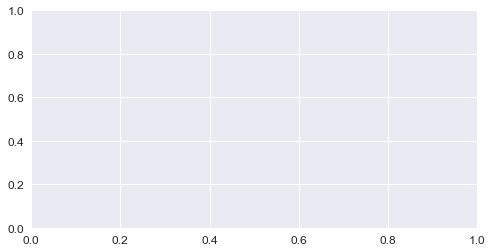

In [17]:
#i+=1
train_model(
    model, 
    dataset, 
    model_path + "model.h5",
    learning_rate=1e-3,
    #log_dir=None#"./logs/H/" + name + "_" + "x".join(list(map(str, structure))) + "_" + str(i)
)